+ Requirements:
    1. The "tools_camera.py" file.
    2. Images of the "imgs/calibration" and "imgs/calibration_wide" directories for the example calibration with OpenCV functionality.
    3. The estimated time to carry out this activity is approximately half an hour.
<br><br>
+ Objectives of the notebook:
    1. Calibrate the model of a camera.
<br><br>
+ Summary of activities:
    1. Code implemented in Python with Numpy will be analyzed.
    2. Code implemented with OpenCV functionality will be analyzed.

# Camera calibration

The calibration process consists of estimating the projection matrix $^{d}\mathbf{M}_w$ of a camera. We know that this matrix allows us to calculate the undistorted image pixels $\mathbf{p}_{d}$ from the world points $\mathbf{p}_w$.

$$ \mathbf{p}_{d} = \begin{bmatrix} s \, u \\ s \, v \\ s \end{bmatrix} ;\:\:\:\: \mathbf{p}_ {w} = \begin{bmatrix} {X}_w \\ {Y}_w \\ {Z}_w \\ 1 \end{bmatrix} ;\:\:\:\: \mathbf{p}_{d } = \, ^{d}\mathbf{M}_w \cdot \mathbf{p}_w$$

$$\begin{bmatrix} s \, u \\ s \, v \\ s \end{bmatrix} = \begin{bmatrix} {m}_{11}&{m}_{12}&{m}_{13}&{m}_{14} \\ {m}_{21}&{m}_{22}&{m}_{23}&{m}_{24} \\ {m}_{31}&{m}_{32}&{m}_{33}&{m}_{34} \end{bmatrix} \cdot \begin{bmatrix} {X}_w \\ {Y}_w \\ {Z}_w \\ 1 \end{bmatrix} $$

Calibrating a camera consists of solving the following system of equations [(Faugueras)](https://polibuscador.upv.es/permalink/f/6lh1qt/alma2139627090003706), based on $n$ (at least 6) correspondences between non-coplanar world points $\mathbf{p}_w$ with their respective pixels projected onto the image $\mathbf{p}_{d}$.

$$ \mathbf{A} \cdot \mathbf{m} = \mathbf{0} $$

$$\begin{bmatrix} 
{X}_1 & {Y}_1 & {Z}_1 & 1 & 0 & 0 & 0 & 0 & -{u}_1\,{X}_1 & -{u}_1\,{Y}_1 & -{u}_1\,{Z}_1 & -{u}_1 \\
0 & 0 & 0 & 0 & {X}_1 & {Y}_1 & {Z}_1 & 1 & -{v}_1\,{X}_1 & -{v}_1\,{Y}_1 & -{v}_1\,{Z}_1 & -{v}_1 \\
.. & .. & .. & .. & .. & .. & .. & .. & .. & .. & .. & .. \\
{X}_n & {Y}_n & {Z}_n & 1 & 0 & 0 & 0 & 0 & -{u}_n\,{X}_n & -{u}_n\,{Y}_n & -{u}_n\,{Z}_n & -{u}_n \\
0 & 0 & 0 & 0 & {X}_n & {Y}_n & {Z}_n & 1 & -{v}_n\,{X}_n & -{v}_n\,{Y}_n & -{v}_n\,{Z}_n & -{v}_n \\
\end{bmatrix} \cdot
\begin{bmatrix}
{m}_{11} \\ {m}_{12} \\ .. \\ {m}_{33} \\ {m}_{34}
\end{bmatrix}
= \mathbf{0} \\
$$

$$ {m}_{34} = 1 \:\:\: \implies \:\:\: \mathbf{A^{'}} \cdot \mathbf{m^{'}} = \mathbf{b} \:\:\: \implies \:\:\: \mathbf{m^{'}} = (\mathbf{A^{'T}} \mathbf{A^{'}})^{-1} \mathbf{A^{'T}} \, \, \mathbf{b} $$

# Calibration example in Python

In [1]:
import numpy as np
import cv2
import os
from PIL import Image
from torchvision.transforms import transforms
from math import pi
import math
import random
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output, Image, display, HTML  # functionality to display images in the notebook
import tools_camera as ca
import glob
import pickle
import yaml

In [2]:
"""World points"""
nPuntos = 6
amplitudX = 500
amplitudY = 500
amplitudZ = 500

nPuntos_mitad = int(nPuntos/2)
nPuntos_resto = int(nPuntos - nPuntos_mitad)

x = (np.random.rand(1, nPuntos) - 0.5) * amplitudX
y = np.concatenate( ( np.random.rand(1, nPuntos_mitad) * amplitudY, np.zeros((1, nPuntos_resto)) ), axis=1 )
z = np.concatenate( ( np.zeros((1, nPuntos_mitad)), np.random.rand(1, nPuntos_resto) * amplitudZ ), axis=1 )
X =  np.concatenate( (x,y,z,np.ones((1,nPuntos))), axis=0)

if nPuntos == 6:
    print('"World points:')
    print(ca.ndtotext(X))

"World points:
┌─────────────────────────────────────────────┐
 [-156.52 -230.84  93.39 116.13 221.89 -42.80] 
 [ 330.91  483.16 269.64   0.00   0.00   0.00] 
 [   0.00    0.00   0.00  48.49 455.90 468.86] 
 [   1.00    1.00   1.00   1.00   1.00   1.00] 
└─────────────────────────────────────────────┘


In [3]:
"""Intrinsec parameters"""
fu = 1580  # fu = f/dx
fv = 1580  # fv = f/dy
uo = 350  # uo = xo
vo = 300  # vo = yo

"""Extrinsec parameters"""
radio = 1000
angulo = 180 - 45

"""CAMERA MODEL"""
cam = ca.Cam(fu, fv, uo, vo, radio, angulo)

Projection matrix:
┌─────────────────────────┐
 [1.58 -0.25 -0.25 350.00] 
 [0.00 -1.33  0.91 300.00] 
 [0.00 -0.00 -0.00   1.00] 
└─────────────────────────┘


In [4]:
"""Image points (in pixels)"""
U=cam.project(X)

if nPuntos == 6:
    print('Image points (in pixels):')
    print(ca.ndtotext(U))

Image points (in pixels):
┌───────────────────────────────────────────────┐
 [  27.17 -203.99 532.32 540.00  867.37  248.84] 
 [-182.62 -519.93 -72.21 356.10 1051.66 1083.62] 
 [   1.00    1.00   1.00   1.00    1.00    1.00] 
└───────────────────────────────────────────────┘


In [5]:
"""Noise introduction in coordinates points"""
ruidoM = 0.1 # Noise added to world points
ruidoI = 0.5 # Noise added to image points

Xr = X + np.concatenate((np.array((np.random.rand(3, nPuntos) - 0.5) * ruidoM), np.zeros((1, nPuntos))))  # mundo
Ur = U + np.concatenate((np.array((np.random.rand(2, nPuntos) - 0.5) * ruidoI), np.zeros((1, nPuntos))))  # imagen

if nPuntos == 6:
    print('Noisy world points:')
    #np.set_printoptions(precision=4)
    print(ca.ndtotext(Xr))
    print('Noisy image points:')
    print(ca.ndtotext(Ur))

Noisy world points:
┌─────────────────────────────────────────────┐
 [-156.55 -230.80  93.37 116.11 221.87 -42.81] 
 [ 330.89  483.17 269.67  -0.04   0.04  -0.01] 
 [  -0.05    0.04   0.05  48.44 455.95 468.86] 
 [   1.00    1.00   1.00   1.00   1.00   1.00] 
└─────────────────────────────────────────────┘
Noisy image points:
┌───────────────────────────────────────────────┐
 [  27.37 -203.94 532.28 540.12  867.32  248.64] 
 [-182.57 -520.01 -72.05 355.86 1051.82 1083.58] 
 [   1.00    1.00   1.00   1.00    1.00    1.00] 
└───────────────────────────────────────────────┘


In [6]:
"""Data normalization"""
[Xn, Tx] = ca.normal(Xr)
[Un, Tu] = ca.normal(Ur)

if nPuntos == 6:
    print('Normalized projected point (in pixels):')
    print(ca.ndtotext(Un))

Normalized projected point (in pixels):
┌───────────────────────────────────┐
 [-0.47 -0.83  0.30 0.32 0.82 -0.13] 
 [-0.72 -1.24 -0.55 0.11 1.18  1.23] 
 [ 1.00  1.00  1.00 1.00 1.00  1.00] 
└───────────────────────────────────┘


In [7]:
"""Camera calibration with normalized points"""
PestN, covarzaN = ca.minEst(Xn, Un)

In [8]:
"""Un-normalize without taking into account the variance"""
PestN1 = np.transpose(PestN)
PestN1.resize(3,4)
Pest1 = np.dot(np.dot(np.linalg.inv(Tu), PestN1), Tx)

Pest1=Pest1/Pest1[2][3]
print('Calibrated projection matrix:')
print(ca.ndtotext(Pest1))

Calibrated projection matrix:
┌─────────────────────────┐
 [1.58 -0.25 -0.25 350.43] 
 [0.00 -1.33  0.90 299.78] 
 [0.00 -0.00 -0.00   1.00] 
└─────────────────────────┘


In [9]:
"""Un-normalize taking into account the variance"""
Tu = np.linalg.inv(Tu)
Tu = np.concatenate(
    (np.concatenate((Tu[0][0] * np.identity(4), Tu[0][1] * np.identity(4), Tu[0][2] * np.identity(4)), axis=1),
     np.concatenate((Tu[1][0] * np.identity(4), Tu[1][1] * np.identity(4), Tu[1][2] * np.identity(4)), axis=1),
     np.concatenate((Tu[2][0] * np.identity(4), Tu[2][1] * np.identity(4), Tu[2][2] * np.identity(4)), axis=1)))
Tx = np.transpose(Tx)
Tx = np.concatenate((np.concatenate((Tx, np.zeros((4, 8))), axis=1),
                     np.concatenate((np.zeros((4, 4)), Tx, np.zeros((4, 4))), axis=1),
                     np.concatenate((np.zeros((4, 8)), Tx), axis=1)))

PestN.resize((12, 1))
Pnorm = np.dot(np.dot(Tx, Tu), PestN)
PnormV = np.dot(np.dot(np.dot(np.dot(Tx, Tu), covarzaN), np.transpose(Tu)), np.transpose(Tx))

"""Estimating parameters extracted from the calibrated projection matrix"""
Pm, Pvar = ca.param(Pnorm, PnormV)

#('fu','fv','u0','v0','tx','ty','tz')
print('Real parameters:')
cTw = cam.get_extrinsec_matrix()
real_values = np.array([[fu, fv, uo, vo, cTw[0,3], cTw[1,3], cTw[2,3]]])
print(ca.ndtotext(real_values))
print('Estimated parameters:')
print(ca.ndtotext(np.transpose(Pm)))
print('Estimated variances:')
print(ca.ndtotext(np.transpose(Pvar)))

Real parameters:
┌─────────────────────────────────────────────────┐
 [1580.00 1580.00 350.00 300.00 0.00 0.00 1000.00] 
└─────────────────────────────────────────────────┘
Estimated parameters:
┌─────────────────────────────────────────────────┐
 [1574.27 1574.22 351.65 298.76 -0.77 0.64 997.62] 
└─────────────────────────────────────────────────┘
Estimated variances:
┌───────────────────────────────────────────┐
 [-0.05 -0.05 -0.06 -0.07 -0.03 -0.03 -0.02] 
└───────────────────────────────────────────┘


In [10]:
"""Retroprojection error estimation"""
Ur_est = np.dot(Pest1, Xr)
Ur_est = np.concatenate([[Ur_est[0] / Ur_est[2]], [Ur_est[1] / Ur_est[2]], [np.ones(Ur_est[0].shape)]])
resta = np.concatenate(([U[0] - Ur_est[0]], [U[1] - Ur_est[1]]))
dista = np.diag(np.dot(np.transpose(resta), resta))
error_retroproyeccion = np.mean(np.sqrt(dista))
        
print('error_retroproyeccion:', error_retroproyeccion)

error_retroproyeccion: 0.18697346542905327


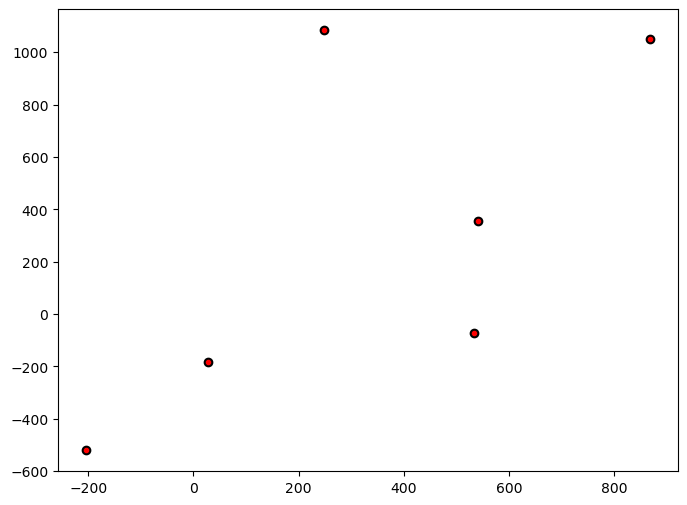

In [11]:
"""The image is displayed comparing the original pixels with the pixels projected with the calibrated matrix"""
fig = plt.figure(figsize=(8,6))
plt.plot(U[0][:nPuntos_mitad], U[1][:nPuntos_mitad], marker='o', ls='', color='k');
plt.plot(U[0][nPuntos_mitad:], U[1][nPuntos_mitad:], marker='o', ls='', color='k');
plt.plot(Ur_est[0], Ur_est[1], marker='.', ls='', color='r');

# Calibration example using OpenCV functionality
OpenCV uses the calibration method of [Zhang](http://ieeexplore.ieee.org/document/888718) which starts from several images of coplanar world points. This way the calibration pattern is much easier to build, since a pattern can simply be printed with a printer.

In [12]:
""""Extraction of pairs of world points and their corresponding projected points in pixels"""
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('imgs/calibration/left*.jpg')
#images = glob.glob('calibration/*.bmp')
#images = glob.glob('imgs/calibration/left*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [13]:
"""Camera calibration"""
# Do camera calibration given object points and image points
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
#print('ret:', ret, 'mtx:', mtx, 'dist:', dist, 'rvecs:', rvecs, 'tvecs:', tvecs)

#S = cv2.calibrationMatrixValues(mtx, img_size, 6.17, 4.55);
#print(S)
#fovx	Output field of view in degrees along the horizontal sensor axis.
#fovy	Output field of view in degrees along the vertical sensor axis.
#focalLength	Focal length of the lens in mm.
#principalPoint	Principal point in mm.
#aspectRatio	fy/fx

# Show P of the first calibration image
K = mtx
R = cv2.Rodrigues(rvecs[0])[0]
T = tvecs[0]
RT = np.concatenate((R,T),axis=1)
Pest0 = np.dot(K, RT)

#print('Matriz de intrínsecos:')
#print(ca.ndtotext(K))

#print('Matriz de rotación:')
#print(ca.ndtotext(R))

#print('Vector de traslación:')
#print(ca.ndtotext(T)

print('Projection matrix for image0:')
print(ca.ndtotext(Pest0))

Projection matrix for image0:
┌────────────────────────────────┐
 [-172.97 487.71  361.09 3403.95] 
 [-552.32  85.52 -157.08 4506.01] 
 [  -0.65  -0.09    0.75   13.41] 
└────────────────────────────────┘


In [14]:
"""Save the camera calibration result for later use (we won't worry about rvecs / tvecs)"""
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "imgs/calibration_wide/wide_dist_pickle.p", "wb" ) )

In [15]:
"""Show error in the first image with OpenCV funcionality"""
U = cv2.projectPoints(objpoints[0], rvecs[0], tvecs[0], mtx, dist)
error = np.asarray(U[0][:,0]-imgpoints[0][:,0,:])
error = np.linalg.norm(error)/len(error)
print("Retroprojection error with OpcenCV for first image:", error)

# Show error in the first image with Python funcionality
mpoints = np.transpose(objpoints[0])
n_points = len(mpoints[0])
lista_ones = np.ones((1,n_points)).tolist()
mpoints =  np.append(mpoints, lista_ones, axis=0)

U = np.dot(Pest0, mpoints)
U = [ [U[0] / U[2]], [U[1] / U[2]] ]
U = np.reshape(np.array(U, dtype="float32").transpose(), (n_points,1,2))

imgpoints_nd = cv2.undistortPoints(imgpoints[0], mtx, dist, None, mtx)
error1 = U-imgpoints_nd
error1 = np.linalg.norm(error1)/len(error1)
#error1 = cv2.norm(U, imgpoints_nd, cv2.NORM_L2)/len(imgpoints_nd)
print("Retroprojection error for first image:",error1)

Retroprojection error with OpcenCV for first image: 0.0622674028078715
Retroprojection error for first image: 0.06541403134663899


Text(0.5, 1.0, 'Undistorted Image')

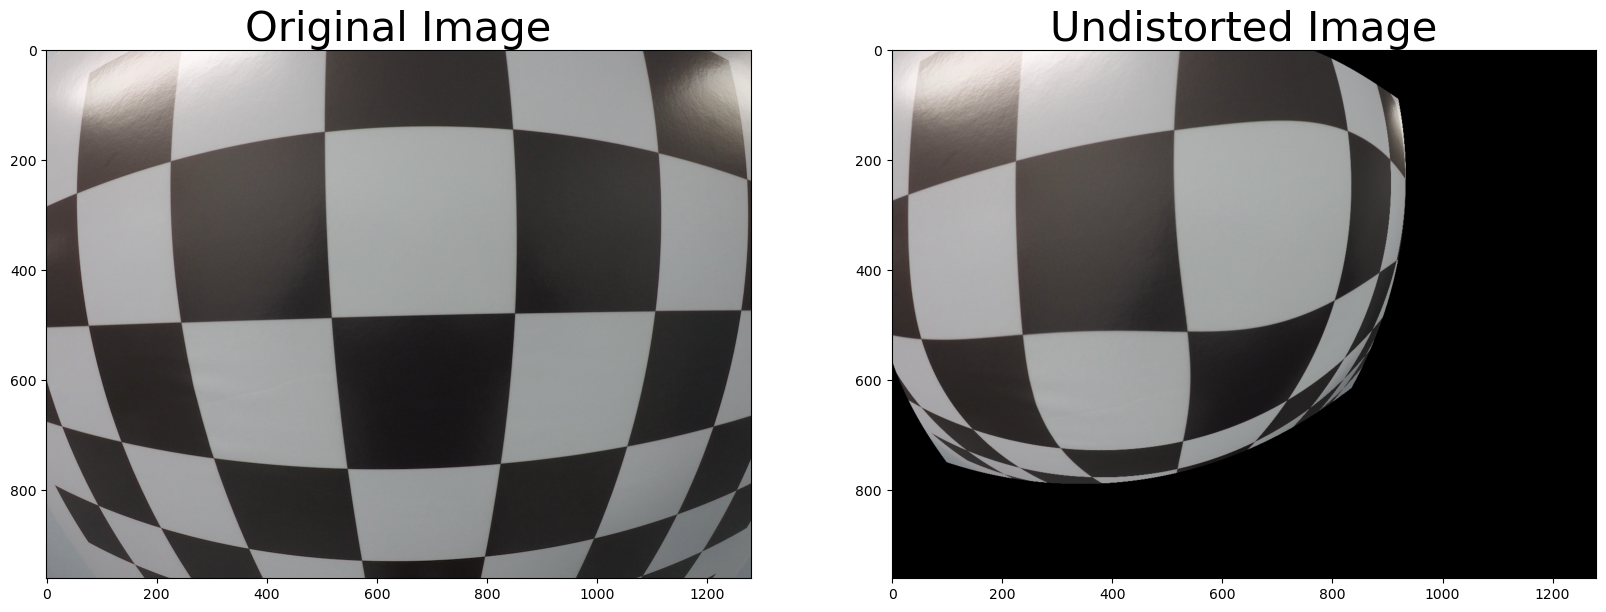

In [17]:
""""Display an undistorted Test image"""
img = cv2.imread('imgs/calibration_wide/test_image.jpg')
#img = cv2.imread('test_pics/000044.bmp')
dst = cv2.undistort(img, mtx, dist, None, mtx)
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
#cv2.imwrite('imgs/calibration_wide/test_undist.jpg',dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

[array([[-1.28948145e+01,  3.63587665e+01,  2.53762928e+02],
       [-4.11747818e+01,  6.37533137e+00,  3.35920667e+02],
       [-4.87444655e-02, -6.52576641e-03,  1.00000000e+00]]), array([[ 3.31509244e+01, -2.21141848e+01,  3.13460185e+02],
       [ 9.19120250e+00,  3.41948877e+01,  7.69408288e+01],
       [-1.84453316e-02, -1.87503247e-02,  1.00000000e+00]]), array([[ 3.35308518e+01, -3.40851151e+00,  2.20497965e+02],
       [-4.97563627e+00,  3.89124621e+01,  1.23915987e+02],
       [-1.86888876e-02, -8.43673396e-03,  1.00000000e+00]]), array([[-4.54260122e+00, -4.15525157e+01,  4.53201783e+02],
       [ 2.88955793e+01,  1.09953974e+01,  7.14749320e+01],
       [-3.81528552e-02,  2.80192664e-03,  1.00000000e+00]]), array([[ 1.22377179e+00,  2.05585621e+01,  3.94532667e+02],
       [-3.40613123e+01, -2.39115478e+00,  3.59156414e+02],
       [-5.17103894e-03, -2.66337833e-02,  1.00000000e+00]]), array([[ 1.11348889e+01,  2.19416872e+01,  1.52974809e+02],
       [-2.93674589e+01,  4.6

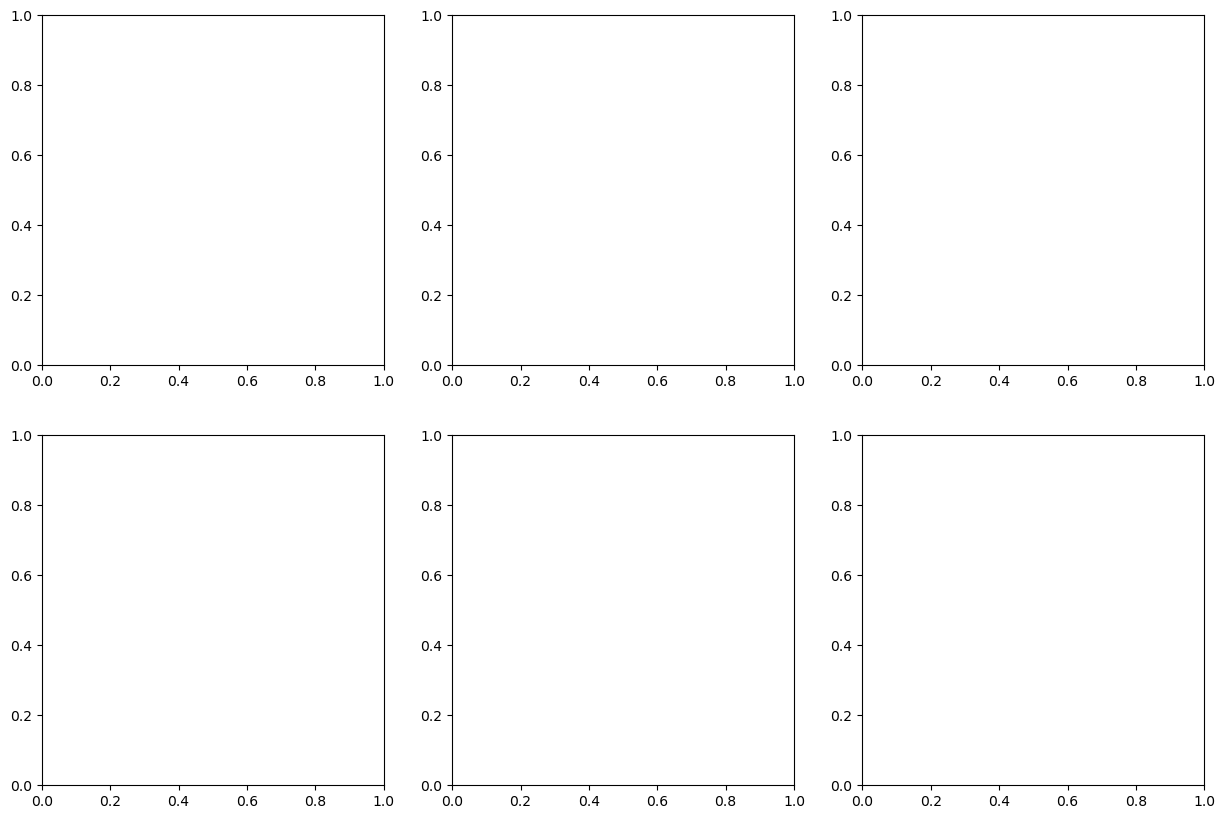